<a href="https://colab.research.google.com/github/jugal-krishna/Reinforcement-Learning/blob/main/RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Download and import the MIT 6.S191 package
!printf "Installing MIT deep learning package... "
!pip install --upgrade git+https://github.com/aamini/introtodeeplearning.git &> /dev/null
!echo "Done"

Installing MIT deep learning package... Done


In [2]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils &> /dev/null
!pip install gym pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
!pip install tensorflow_probability==0.12.0 &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib, cv2
import matplotlib.pyplot as plt
import base64, io, os, time, gym
import IPython, functools
import time
from tqdm import tqdm
import tensorflow_probability as tfp

import mitdeeplearning as mdl

In [3]:
# Install Vista Simulator

!pip install --upgrade git+https://github.com/vista-simulator/vista-6s191.git

  Cloning https://github.com/vista-simulator/vista-6s191.git to /tmp/pip-req-build-58g6c1s7
  Running command git clone -q https://github.com/vista-simulator/vista-6s191.git /tmp/pip-req-build-58g6c1s7


In [4]:
import vista
from vista.utils import logging
logging.setLevel(logging.ERROR)

2022-04-11 18:25:46,665::WARNING::[vista.entities.sensors.EventCamera.<module>] Fail to import module for event camera. Remember to do source <some-dir>/openeb/build/utils/scripts/setup_env.shCan ignore this if not using it


In [5]:
### Access documentation for VISTA
### Run ?vista.<[name of module or function]>
?vista.Display 

Unzipping data...
Done downloading and unzipping data!


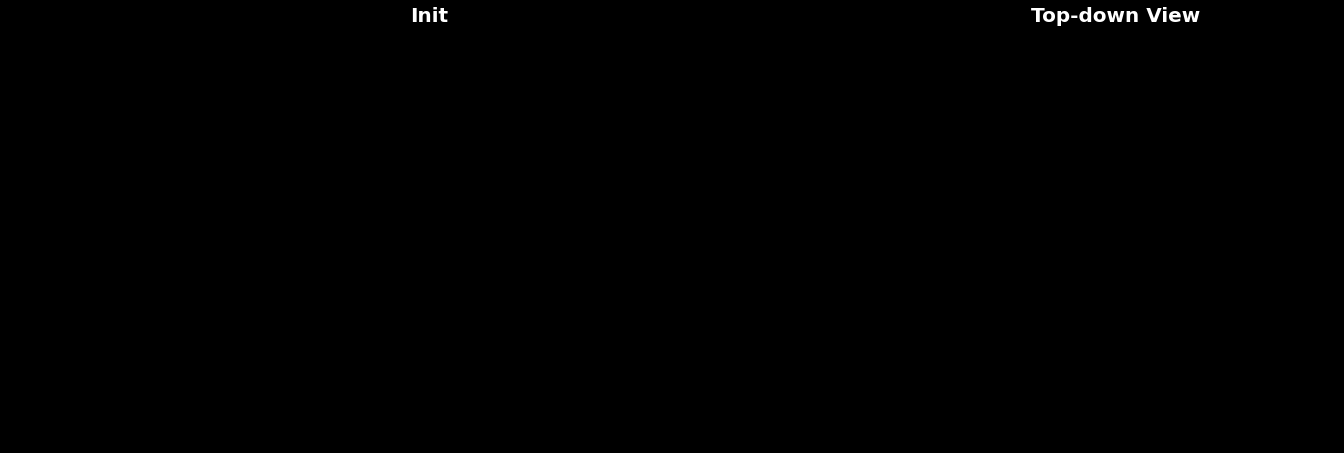

In [6]:
# Create environment from VISTA

# Download and extract the data for vista (auto-skip if already downloaded)
!wget -nc -q --show-progress https://www.dropbox.com/s/62pao4mipyzk3xu/vista_traces.zip
print("Unzipping data...")
!unzip -o -q vista_traces.zip
print("Done downloading and unzipping data!")

trace_root = "./vista_traces"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]

# Create a virtual world with VISTA, the world is defined by a series of data traces
world = vista.World(trace_path, trace_config={'road_width': 4})

# Create a car in our virtual world. The car will be able to step and take different 
#   control actions. As the car moves, its sensors will simulate any changes it environment
car = world.spawn_agent(
    config={
        'length': 5.,
        'width': 2.,
        'wheel_base': 2.78,
        'steering_ratio': 14.7,
        'lookahead_road': True
    })

# Create a camera on the car for synthesizing the sensor data that we can use to train with! 
camera = car.spawn_camera(config={'size': (200, 320)})

# Define a rendering display so we can visualize the simulated car camera stream and also 
#   get see its physical location with respect to the road in its environment. 
display = vista.Display(world, display_config={"gui_scale": 2, "vis_full_frame": False})

# Define a simple helper function that allows us to reset VISTA and the rendering display
def vista_reset():
    world.reset()
    display.reset()
vista_reset()

In [7]:
# First we define a step function, to allow our virtual agent to step 
# with a given control command through the environment 
# agent can act with a desired curvature (turning radius, like steering angle)
# and desired speed. if either is not provided then this step function will 
# use whatever the human executed at that time in the real data.

def vista_step(curvature=None, speed=None):
    # Arguments:
    #   curvature: curvature to step with
    #   speed: speed to step with
    if curvature is None: 
        curvature = car.trace.f_curvature(car.timestamp)
    if speed is None: 
        speed = car.trace.f_speed(car.timestamp)
    
    car.step_dynamics(action=np.array([curvature, speed]), dt=1/15.)
    car.step_sensors()

In [8]:
import shutil, os, subprocess, cv2

# Create a simple helper class that will assist us in storing videos of the render
class VideoStream():
    def __init__(self):
        self.tmp = "./tmp"
        if os.path.exists(self.tmp) and os.path.isdir(self.tmp):
            shutil.rmtree(self.tmp)
        os.mkdir(self.tmp)
    def write(self, image, index):
        cv2.imwrite(os.path.join(self.tmp, f"{index:04}.png"), image)
    def save(self, fname):
        cmd = f"/usr/bin/ffmpeg -f image2 -i {self.tmp}/%04d.png -crf 0 -y {fname}"
        subprocess.call(cmd, shell=True)
        

In [ ]:
## Render and inspect a human trace ##

vista_reset()
stream = VideoStream()

for i in tqdm(range(100)):
    vista_step()
    
    # Render and save the display
    vis_img = display.render()
    stream.write(vis_img[:, :, ::-1], index=i)
    if car.done: 
        break

print("Saving trajectory of human following...")
stream.save("human_follow.mp4")      
mdl.lab3.play_video("human_follow.mp4")

In [9]:
## Define terminal states and crashing conditions ##

def check_out_of_lane(car):
    distance_from_center = np.abs(car.relative_state.x)
    road_width = car.trace.road_width 
    half_road_width = road_width / 2
    return distance_from_center > half_road_width

def check_exceed_max_rot(car):
    maximal_rotation = np.pi / 10.
    current_rotation = np.abs(car.relative_state.yaw)
    return current_rotation > maximal_rotation

def check_crash(car): 
    return check_out_of_lane(car) or check_exceed_max_rot(car) or car.done

In [ ]:
## Behavior with random control policy ##

i = 0
num_crashes = 5
stream = VideoStream()

for _ in range(num_crashes):
    vista_reset()
    
    while not check_crash(car):

        # Sample a random curvature (between +/- 1/3), keep speed constant
        curvature = np.random.uniform(-1/3, 1/3)

        # Step the simulated car with the same action
        vista_step(curvature=curvature)

        # Render and save the display
        vis_img = display.render()
        stream.write(vis_img[:, :, ::-1], index=i)
        i += 1
    
    print(f"Car crashed on step {i}")
    for _ in range(5):
        stream.write(vis_img[:, :, ::-1], index=i)
        i += 1

print("Saving trajectory with random policy...")
stream.save("random_policy.mp4")
mdl.lab3.play_video("random_policy.mp4")

In [ ]:
from google.colab.patches import cv2_imshow

# Directly access the raw sensor observations of the simulated car
vista_reset()
full_obs = car.observations[camera.name]
cv2_imshow(full_obs)

In [ ]:
## ROIs ##
import PIL
# Crop a smaller region of interest (ROI). This is necessary because: 
#   1. The full observation will have distortions on the edge as the car deviates from the human
#   2. A smaller image of the environment will be easier for our model to learn from
region_of_interest = camera.camera_param.get_roi()
i1, j1, i2, j2 = region_of_interest
cropped_obs = full_obs[i1:i2, j1:j2]
print(f'Initial size = {np.shape(cropped_obs)}')
new_img = tf.image.resize(
    cropped_obs,
    [224,224])
print(f'Final size = {tf.shape(new_img)}')
cv2_imshow(cropped_obs)
def tensor_to_image(tensor):
    tensor = tensor
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
tensor_to_image(new_img)

In [67]:
## Data preprocessing functions ##

# Takes a full observation as input and returns a preprocessed version
def preprocess(full_obs):
    # Extract ROI
    i1, j1, i2, j2 = camera.camera_param.get_roi()
    obs = full_obs[i1:i2, j1:j2]
    obs = tf.image.resize(obs,[224,224])

    return obs
# grab the car's current observation (i.e., image view from its perspective), and then call the preprocess function on that observation
def grab_and_preprocess_obs(car):
    full_obs = car.observations[camera.name]
    obs = preprocess(full_obs)
    return obs

In [58]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [59]:
tf.keras.Input(shape=(224,224,3))

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_16')>

In [60]:
### Define the self-driving agent ###

# Functionally define layers for convenience
# All convolutional layers will have ReLu activation
act = tf.keras.activations.swish
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='valid', activation=act)
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Defines a CNN for the self-driving agent
def create_driving_model():


# Download pre-trained ResNet50
  resnet = tf.keras.applications.ResNet50(weights='imagenet',
                                 include_top=False, 
                                 input_tensor=tf.keras.Input(shape=(224,224,3)),
                                 input_shape=(224,224,3))
  for layer in resnet.layers[:170]:
    layer.trainable = False
  
  model = tf.keras.models.Sequential([
      resnet,
      Flatten(),

      # Fully connected layer and output
      Dense(units=128, activation=act),

      Dense(units=2, activation=None) # TODO
      # Dense('''TODO''')

  ])
  return model

driving_model = create_driving_model()

In [61]:
## The self-driving learning algorithm ##

# hyperparameters
max_curvature = 1/8. 
max_std = 0.1 

def run_driving_model(image): 
  # takes an input image, and outputs a prediction of a continuous distribution of curvature
    # Arguments:
    #   image: an input image
    # Returns:
    #   pred_dist: predicted distribution of control actions 
    single_image_input = tf.rank(image) == 3  # missing 4th batch dimension
    if single_image_input:
        image = tf.expand_dims(image, axis=0)

    distribution = driving_model(image) 


    mu, logsigma = tf.split(distribution, 2, axis=1)
    mu = max_curvature * tf.tanh(mu) # conversion
    sigma = max_std * tf.sigmoid(logsigma) + 0.005 # conversion
    pred_dist = tfp.distributions.Normal(mu, sigma) 

    return pred_dist


def compute_driving_loss(dist, actions, rewards):
  # computes the loss for a prediction that is in the form of a continuous Normal distribution
    # Arguments:
    #   logits: network's predictions for actions to take
    #   actions: the actions the agent took in an episode
    #   rewards: the rewards the agent received in an episode
    # Returns:
    #   loss

    neg_logprob = -1 * dist.log_prob(actions)

    loss = tf.reduce_mean( neg_logprob * rewards ) 
    return loss

In [62]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
      
    return normalize(discounted_rewards)

In [63]:
class Memory:
    def __init__(self): 
        self.clear()

  # Resets/restarts the memory buffer
    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

  # Add observations, actions, rewards to memory
    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        
        self.actions.append(new_action)

        self.rewards.append(new_reward)
    def __len__(self):
        return len(self.actions)

# Instantiate a single Memory buffer
memory = Memory()

In [64]:
### Training step (forward and backpropagation) ###

def train_step(model, loss_function, optimizer, observations, actions, discounted_rewards, custom_fwd_fn=None):
    with tf.GradientTape() as tape:
        # Forward propagate through the agent network

        if custom_fwd_fn is not None:
            prediction = custom_fwd_fn(observations)
        else: 
            prediction = model(observations)

        loss = loss_function(prediction, actions, discounted_rewards)
    grads = tape.gradient(loss, model.trainable_variables)

    grads, _ = tf.clip_by_global_norm(grads, 2)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [65]:
## Training parameters and initialization ##
## Re-run this cell to restart training from scratch ##

learning_rate = 5e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate driving agent
vista_reset()
driving_model = create_driving_model()
# NOTE: the variable driving_model will be used in run_driving_model execution

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

# instantiate Memory buffer
memory = Memory()

In [ ]:
## Driving training! Main training block. ##
## Note: stopping and restarting this cell will pick up training where you
#        left off. To restart training you need to rerun the cell above as 
#        well (to re-initialize the model and optimizer)

max_batch_size = 500
max_reward = float('-inf') # keep track of the maximum reward acheived during training
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

    plotter.plot(smoothed_reward.get())
    # Restart the environment
    vista_reset()
    memory.clear()
    observation = grab_and_preprocess_obs(car)

    while True:

        curvature_dist = run_driving_model(observation)
        curvature_action = curvature_dist.sample()[0,0]
        
        # Step the simulated car with the same action
        vista_step(curvature_action)
        observation = grab_and_preprocess_obs(car)
               
        # Compute the reward for this iteration
        reward = 100.0 if not check_crash(car) else 0.0
        
        # add to memory
        memory.add_to_memory(observation, curvature_action, reward)
        
        # if the episode is over
        if reward == 0.0:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            
            # execute training step - remember we don't know anything about how the 
            #   agent is doing until it has crashed! if the training step is too large 
            #   we need to sample a mini-batch for this step.
            batch_size = min(len(memory), max_batch_size)
            i = np.random.choice(len(memory), batch_size, replace=False)
            train_step(driving_model, compute_driving_loss, optimizer, 
                               observations=np.array(memory.observations)[i],
                               actions=np.array(memory.actions)[i],
                               discounted_rewards = discount_rewards(memory.rewards)[i], 
                               custom_fwd_fn=run_driving_model)            
            # reset the memory
            memory.clear()
            break

In [ ]:
## Evaluation block!##

i_step = 0
num_episodes = 5
num_reset = 5
stream = VideoStream()
for i_episode in range(num_episodes):
    
    # Restart the environment
    vista_reset()
    observation = grab_and_preprocess_obs(car)
    
    print("rolling out in env")
    episode_step = 0
    while not check_crash(car) and episode_step < 100:
        # using our observation, choose an action and take it in the environment
        curvature_dist = run_driving_model(observation)
        curvature = curvature_dist.mean()[0,0]

        # Step the simulated car with the same action
        vista_step(curvature)
        observation = grab_and_preprocess_obs(car)

        vis_img = display.render()
        stream.write(vis_img[:, :, ::-1], index=i_step)
        i_step += 1
        episode_step += 1
        
    for _ in range(num_reset):
        stream.write(np.zeros_like(vis_img), index=i_step)
        i_step += 1
        
print(f"Average reward: {(i_step - (num_reset*num_episodes)) / num_episodes}")

print("Saving trajectory with trained policy...")
stream.save("trained_policy.mp4")
mdl.lab3.play_video("trained_policy.mp4")